# CatBoost

**CatBoost**: CatBoost is a Gradient Boosting framework that directly supports categorical variables and is a machine learning algorithm used specifically for classification and regression problems. Developed by Yandex, CatBoost simplifies the data preprocessing process by enabling categorical variables to be automatically processed and integrated into the model.

# Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

!pip install catboost
from catboost import CatBoostClassifier

!pip install joblib
import joblib

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


# General Information About to the Dataset

In [5]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

######################### Head #########################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.6000                    0.6270   50        1
1            1       85             66             29        0 26.6000                    0.3510   31        0
2            8      183             64              0        0 23.3000                    0.6720   32        1
3            1       89             66             23       94 28.1000                    0.1670   21        0
4            0      137             40             35      168 43.1000                    2.2880   33        1
######################### Tail #########################
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
763           10      101             76             48      180 32.9000                    0.1710   63    

# Analysis of Categorical and Numerical Variables

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

In [8]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_But_Cat: {len(num_but_cat)}")

Observations: 768
Variables: 9
Cat_cols: 1
Num_cols: 8
Cat_but_car: 0
Num_But_Cat: 1


In [9]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [10]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

         Outcome  Ration
Outcome                 
0            500 65.1042
1            268 34.8958
##########################################


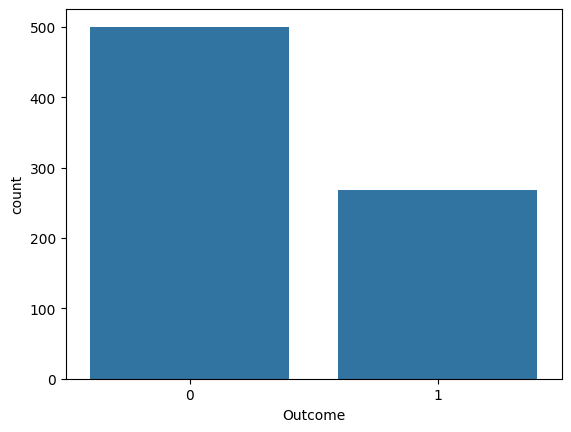

In [11]:
cat_summary_df(df)

In [12]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [13]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   768.0000
mean      3.8451
std       3.3696
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       1.0000
30%       1.0000
40%       2.0000
50%       3.0000
60%       4.0000
70%       5.0000
80%       7.0000
90%       9.0000
95%      10.0000
99%      13.0000
max      17.0000
Name: Pregnancies, dtype: float64


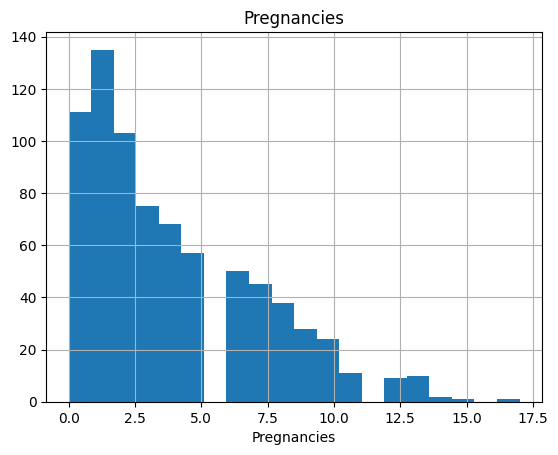

count   768.0000
mean    120.8945
std      31.9726
min       0.0000
1%       57.0000
5%       79.0000
10%      85.0000
20%      95.0000
30%     102.0000
40%     109.0000
50%     117.0000
60%     125.0000
70%     134.0000
80%     147.0000
90%     167.0000
95%     181.0000
99%     196.0000
max     199.0000
Name: Glucose, dtype: float64


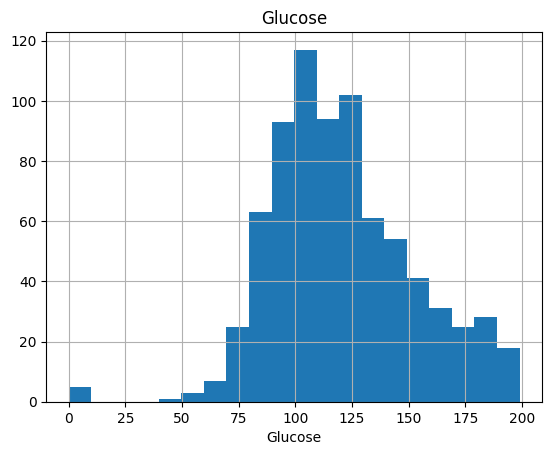

count   768.0000
mean     69.1055
std      19.3558
min       0.0000
1%        0.0000
5%       38.7000
10%      54.0000
20%      60.0000
30%      64.0000
40%      68.0000
50%      72.0000
60%      74.0000
70%      78.0000
80%      82.0000
90%      88.0000
95%      90.0000
99%     106.0000
max     122.0000
Name: BloodPressure, dtype: float64


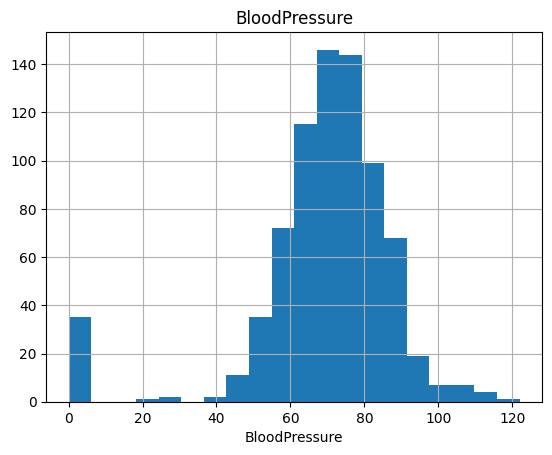

count   768.0000
mean     20.5365
std      15.9522
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       8.2000
40%      18.0000
50%      23.0000
60%      27.0000
70%      31.0000
80%      35.0000
90%      40.0000
95%      44.0000
99%      51.3300
max      99.0000
Name: SkinThickness, dtype: float64


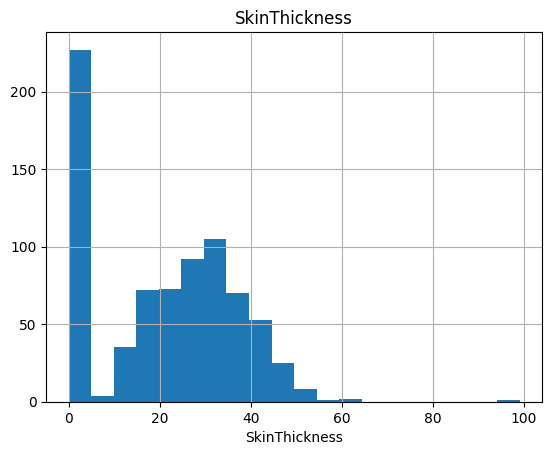

count   768.0000
mean     79.7995
std     115.2440
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       0.0000
40%       0.0000
50%      30.5000
60%      72.2000
70%     106.0000
80%     150.0000
90%     210.0000
95%     293.0000
99%     519.9000
max     846.0000
Name: Insulin, dtype: float64


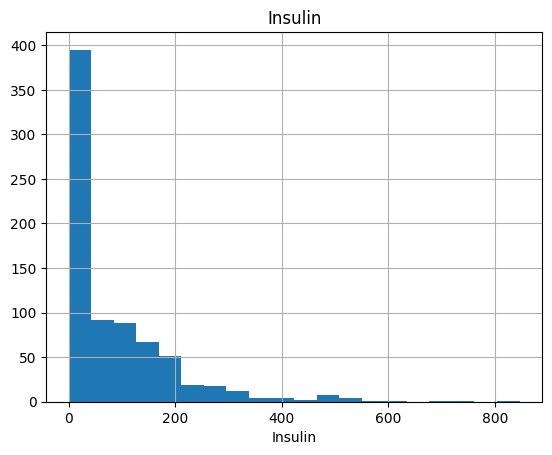

count   768.0000
mean     31.9926
std       7.8842
min       0.0000
1%        0.0000
5%       21.8000
10%      23.6000
20%      25.9000
30%      28.2000
40%      30.1000
50%      32.0000
60%      33.7000
70%      35.4900
80%      37.8000
90%      41.5000
95%      44.3950
99%      50.7590
max      67.1000
Name: BMI, dtype: float64


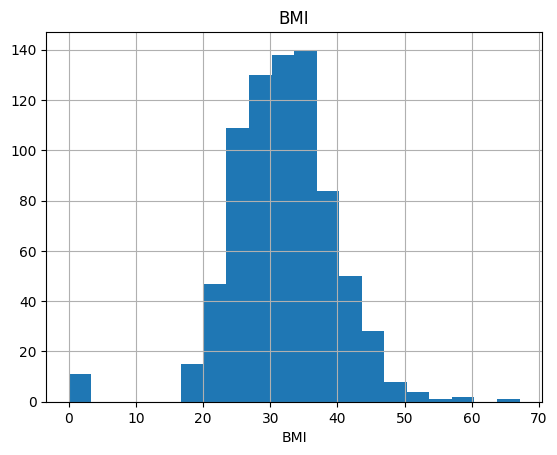

count   768.0000
mean      0.4719
std       0.3313
min       0.0780
1%        0.0947
5%        0.1404
10%       0.1650
20%       0.2194
30%       0.2590
40%       0.3028
50%       0.3725
60%       0.4542
70%       0.5637
80%       0.6870
90%       0.8786
95%       1.1328
99%       1.6983
max       2.4200
Name: DiabetesPedigreeFunction, dtype: float64


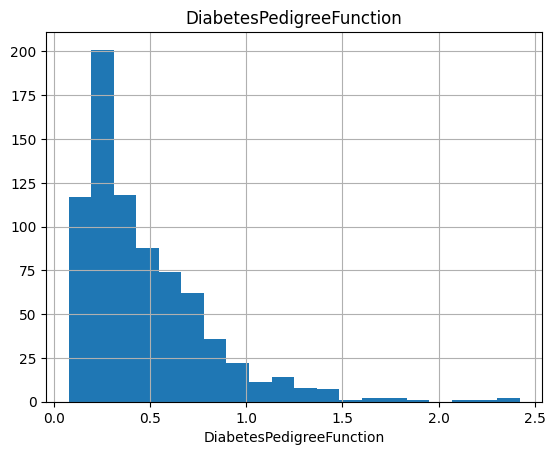

count   768.0000
mean     33.2409
std      11.7602
min      21.0000
1%       21.0000
5%       21.0000
10%      22.0000
20%      23.0000
30%      25.0000
40%      27.0000
50%      29.0000
60%      33.0000
70%      38.0000
80%      42.6000
90%      51.0000
95%      58.0000
99%      67.0000
max      81.0000
Name: Age, dtype: float64


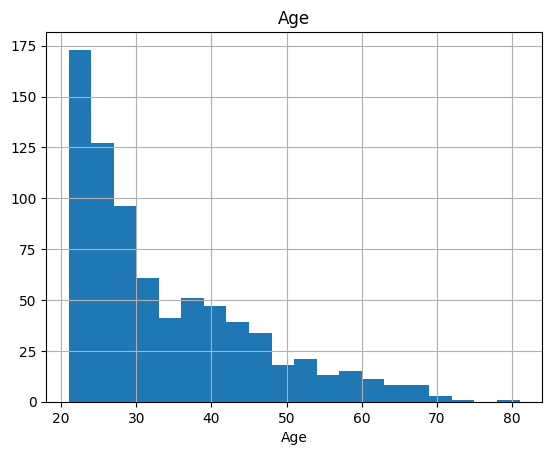

In [14]:
num_summary_df(df)

In [15]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  plt.figure(figsize=(12,8))
  for index, col in enumerate(num_cols):
    plt.subplot(3,3, index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

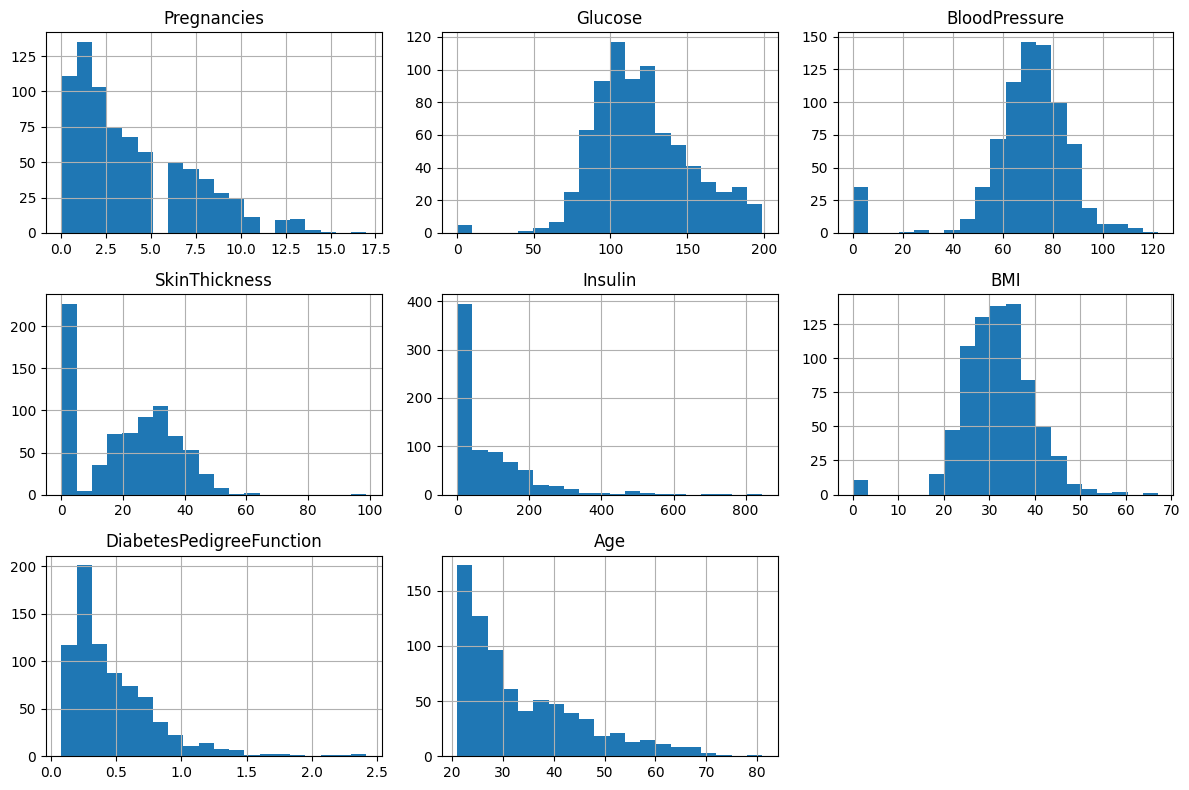

In [16]:
plot_num_summary(df)

# Target Analysis

In [17]:
def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}))
  print("#############################################")

In [18]:
def target_summary_with_num_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in num_cols:
    target_summary_with_num(dataframe, target, col)

In [19]:
target_summary_with_num_df(df, "Outcome")

         Pregnancies
Outcome             
0             3.2980
1             4.8657
#############################################
         Glucose
Outcome         
0       109.9800
1       141.2575
#############################################
         BloodPressure
Outcome               
0              68.1840
1              70.8246
#############################################
         SkinThickness
Outcome               
0              19.6640
1              22.1642
#############################################
         Insulin
Outcome         
0        68.7920
1       100.3358
#############################################
            BMI
Outcome        
0       30.3042
1       35.1425
#############################################
         DiabetesPedigreeFunction
Outcome                          
0                          0.4297
1                          0.5505
#############################################
            Age
Outcome        
0       31.1900
1       37.0672
##########

# Correlation Analysis

In [20]:
def correlated_cols(dataframe, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  print(corr)

  if plot:
    sns.set(rc={'figure.figsize': (14,7)})
    sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")
    plt.show()

                          Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction     Age  Outcome
Pregnancies                    1.0000   0.1295         0.1413        -0.0817  -0.0735 0.0177                   -0.0335  0.5443   0.2219
Glucose                        0.1295   1.0000         0.1526         0.0573   0.3314 0.2211                    0.1373  0.2635   0.4666
BloodPressure                  0.1413   0.1526         1.0000         0.2074   0.0889 0.2818                    0.0413  0.2395   0.0651
SkinThickness                 -0.0817   0.0573         0.2074         1.0000   0.4368 0.3926                    0.1839 -0.1140   0.0748
Insulin                       -0.0735   0.3314         0.0889         0.4368   1.0000 0.1979                    0.1851 -0.0422   0.1305
BMI                            0.0177   0.2211         0.2818         0.3926   0.1979 1.0000                    0.1406  0.0362   0.2927
DiabetesPedigreeFunction      -0.0335   0.1373  

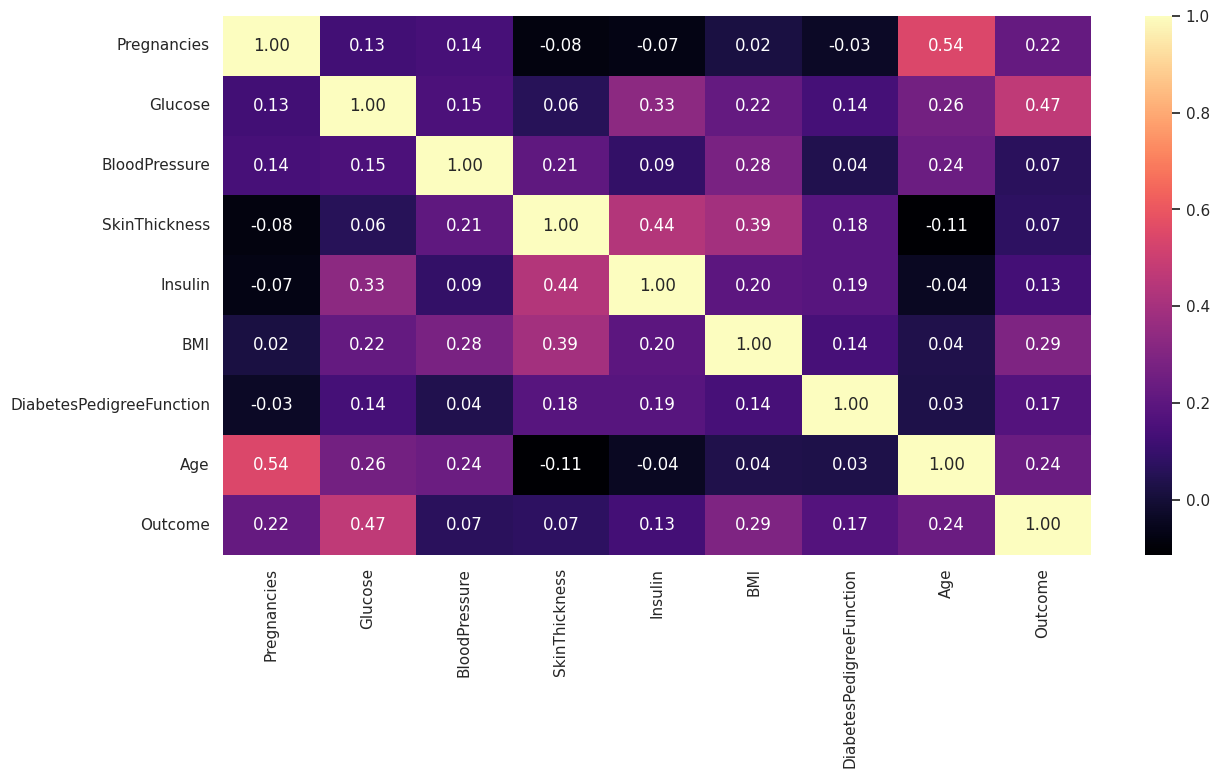

In [21]:
correlated_cols(df, plot=True)

In [22]:
def high_correlated_cols(dataframe, corr_th = 0.90, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  corr_matrix = corr.abs()
  upper_triangular_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangular_matrix.columns if any(upper_triangular_matrix[col] > corr_th)]
  if drop_list == []:
    print("Aftre corelation analysis, we dont need to remove variables")

  if plot:
    sns.set(rc={'figure.figsize': (14,7)})
    sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
    plt.show()

  return drop_list

Aftre corelation analysis, we dont need to remove variables


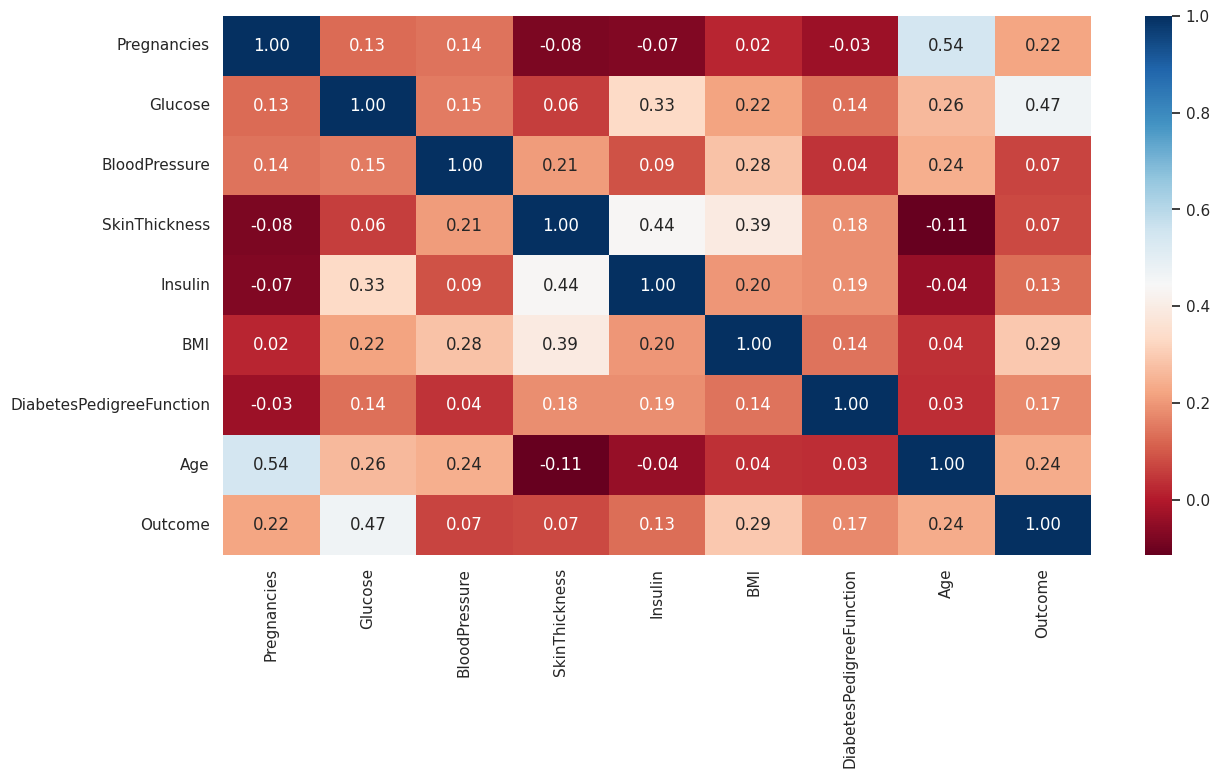

In [23]:
drop_list = high_correlated_cols(df, plot=True)

## Missing Value Analysis

**Not:** It is known that a human cannot have variable values 0 other than Pregnancies and Outcome. Therefore, an action decision should be taken regarding these values. Values that are 0 can be assigned NaN.


In [24]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [25]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
for col in zero_columns:
  df[col] = np.where(df[col]==0, np.nan, df[col])

In [26]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [27]:
def missing_value_table(dataframe, na_names=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

  if na_names:
    print(25*"#", "NA Columns", 25*"#")
    return na_columns

In [28]:
na_columns = missing_value_table(df, na_names=True)

               n_miss   ratio
Insulin           374 48.7000
SkinThickness     227 29.5600
BloodPressure      35  4.5600
BMI                11  1.4300
Glucose             5  0.6500
######################### NA Columns #########################


In [29]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [30]:
df = fill_na_with_median(df)

In [31]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Outlier Analysis

In [32]:
def outlier_thresholds(dataframe,col_name,q1=0.05,q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit

In [33]:
def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [34]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [35]:
for col in df.columns:
  print(col, check_outlier(df, col))
  if check_outlier(df, col):
    replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [36]:
for col in df.columns:
  print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


# Encoding & Scaling

In [37]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

In [38]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [39]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

In [40]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]
def one_hot_encoding(dataframe, cat_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
    return dataframe

In [41]:
df = one_hot_encoding(df, cat_cols, drop_first=True)

In [42]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50,1
1,1,85.0000,66.0000,29.0000,125.0000,26.6000,0.3510,31,0
2,8,183.0000,64.0000,29.0000,125.0000,23.3000,0.6720,32,1
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21,0
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,2.2880,33,1


# Create a Base Model: CatBoost Classifier

**CatBoost**: CatBoost is a Gradient Boosting framework that directly supports categorical variables and is a machine learning algorithm used specifically for classification and regression problems. Developed by Yandex, CatBoost simplifies the data preprocessing process by enabling categorical variables to be automatically processed and integrated into the model.

In [59]:
def CatBoost_Model(dataframe, target, test_size=0.30, cv=10, results=False, conf_matrix=False, c_report=False, roc=False, plot_importance=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

  catboost_model = CatBoostClassifier(verbose=False).fit(X_train, y_train)

  if results:
    acc_train = accuracy_score(y_train, catboost_model.predict(X_train))
    acc_test = accuracy_score(y_test, catboost_model.predict(X_test))
    r2 = catboost_model.score(X, y)
    r2_train = catboost_model.score(X_train, y_train)
    r2_test = catboost_model.score(X_test, y_test)
    cv_train = cross_val_score(catboost_model, X_train, y_train, cv=cv).mean()
    cv_test = cross_val_score(catboost_model, X_test, y_test, cv=cv).mean()
    cv_results = cross_validate(catboost_model, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    print("##################### Accuracy & R2 Metrics ######################")
    print("Accuracy_train: ", "%.3f" % acc_train)
    print("Accuracy_test: ", "%.3f" % acc_test)
    print("R2: ", "%.3f" % r2)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)
    print("Cross Validation Score(Train): ", "%.3f" % cv_train)
    print("Cross Validation Score(Test): ", "%.3f" % cv_test)
    print("Cross Validate (Accuracy): ", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validate (Precision): ", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validate (Recall): ", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validate (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validate (ROC AUC Score): ", "%.3f" % cv_results['test_roc_auc'].mean())

  if conf_matrix:
    print("##################### Confusion Matrix(Train) ######################")
    print(confusion_matrix(y_train, catboost_model.predict(X_train)))
    print("##################### Confusion Matrix(Test) ######################")
    print(confusion_matrix(y_test, catboost_model.predict(X_test)))
    print("##################### Confusion Matrix(All) ######################")
    print(confusion_matrix(y, catboost_model.predict(X)))
    plt.figure(figsize=(5,5))
    acc = accuracy_score(y, catboost_model.predict(X))
    cm = confusion_matrix(y, catboost_model.predict(X))
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {}'.format(acc), size=10)
    plt.show()

  if c_report:
    print("###################### Classification Report(Train) ######################")
    print(classification_report(y_train, catboost_model.predict(X_train)))
    print("###################### Classification Report(Test) ######################")
    print(classification_report(y_test, catboost_model.predict(X_test)))
    print("###################### Classification Report(All) ######################")
    print(classification_report(y, catboost_model.predict(X)))

  if roc:
    print("###################### Roc Auc Score(Train) ######################")
    catboost_roc_auc_train = roc_auc_score(y_train, catboost_model.predict(X_train))
    print("Roc Auc Train: ", "%.3f" % catboost_roc_auc_train)
    fpr, tpr, thresholds = roc_curve(y_train, catboost_model.predict_proba(X_train)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % catboost_roc_auc_train )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

    print("###################### Roc Auc Score(Test) ######################")
    catboost_roc_auc_test = roc_auc_score(y_test, catboost_model.predict(X_test))
    print("Roc Auc Test: ", "%.3f" % catboost_roc_auc_test)
    fpr, tpr, thresholds = roc_curve(y_test, catboost_model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % catboost_roc_auc_test )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': catboost_model.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(X)])
    plt.title('Features')
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

  if save_model:
    joblib.dump(catboost_model, "catboost_model.pkl")

  return catboost_model

##################### Accuracy & R2 Metrics ######################
Accuracy_train:  0.946
Accuracy_test:  0.797
R2:  0.901
R2_train:  0.946
R2_test:  0.797
Cross Validation Score(Train):  0.741
Cross Validation Score(Test):  0.784
Cross Validate (Accuracy):  0.759
Cross Validate (Precision):  0.681
Cross Validate (Recall):  0.601
Cross Validate (F1):  0.633
Cross Validate (ROC AUC Score):  0.837
##################### Confusion Matrix(Train) ######################
[[350   4]
 [ 25 158]]
##################### Confusion Matrix(Test) ######################
[[131  15]
 [ 32  53]]
##################### Confusion Matrix(All) ######################
[[481  19]
 [ 57 211]]


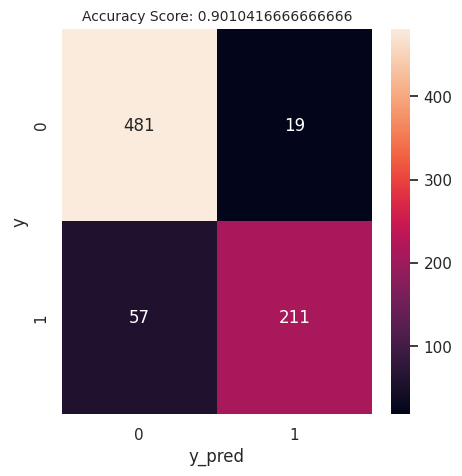

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       354
           1       0.98      0.86      0.92       183

    accuracy                           0.95       537
   macro avg       0.95      0.93      0.94       537
weighted avg       0.95      0.95      0.95       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       146
           1       0.78      0.62      0.69        85

    accuracy                           0.80       231
   macro avg       0.79      0.76      0.77       231
weighted avg       0.79      0.80      0.79       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       500
           1   

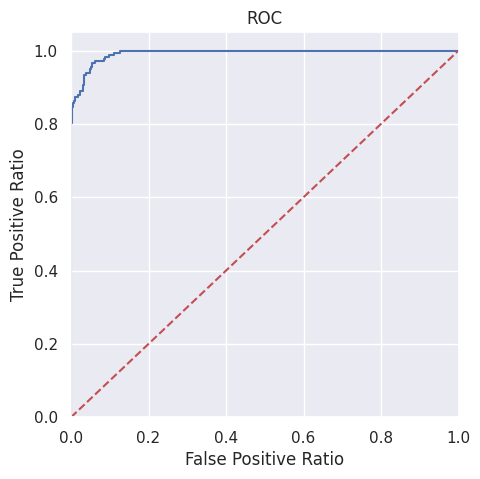

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.760


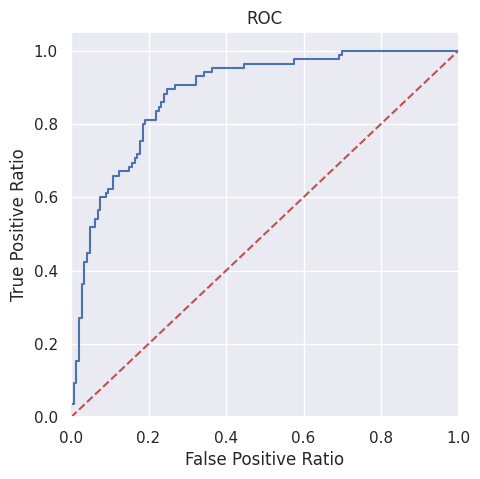

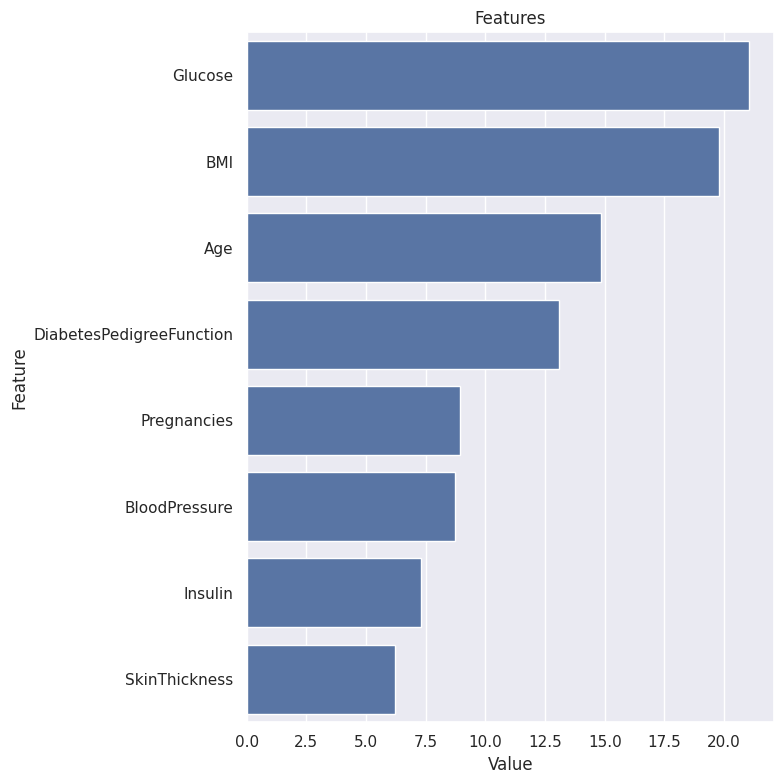

In [60]:
catboost_model = CatBoost_Model(df, "Outcome", results=True, conf_matrix=True, c_report=True, roc=True, plot_importance=True, save_model=True)

# Loading a Base CatBoost Classifier Model and Then Prediction

In [67]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [68]:
model_disc = load_model("catboost_model.pkl")

In [69]:
patient = [[5, 140, 90, 25, 150, 39, 0.55, 65]]
patient= pd.DataFrame(patient,columns=
['Pregnancies','Glucose','BloodPressure','SkinThickness',
'Insulin','BMI','DiabetesPedigreeFunction','Age'],dtype=float)

In [70]:
model_disc.predict(patient)[0]

1

# Create a Model Tuning: CatBoost Classifier

In [82]:
def CatBoost_Model_Tuned(dataframe, target, test_size=0.30, cv=10, results=False, conf_matrix=False, c_report=False, roc=False, plot_importance=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

  catboost_model = CatBoostClassifier(verbose=False)
  catboost_params = {
    "iterations": [200, 500],
    "learning_rate": [0.1, 0.01],
    "depth": [3, 5]
  }
  catboost_cv_model = GridSearchCV(catboost_model, catboost_params, cv=cv, verbose=True, n_jobs=-1).fit(X_train, y_train)
  catboost_model_tuned = catboost_model.set_params(**catboost_cv_model.best_params_).fit(X, y)

  if results:
    acc_train = accuracy_score(y_train, catboost_model_tuned.predict(X_train))
    acc_test = accuracy_score(y_test, catboost_model_tuned.predict(X_test))
    r2 = catboost_model_tuned.score(X, y)
    r2_train = catboost_model_tuned.score(X_train, y_train)
    r2_test = catboost_model_tuned.score(X_test, y_test)
    cv_train = cross_val_score(catboost_model_tuned, X_train, y_train, cv=cv).mean()
    cv_test = cross_val_score(catboost_model_tuned, X_test, y_test, cv=cv).mean()
    cv_results = cross_validate(catboost_model_tuned, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    print("##################### Accuracy & R2 Metrics ######################")
    print("CatBoost Classifier Best Params: ", catboost_cv_model.best_params_)
    print("Accuracy_train: ", "%.3f" % acc_train)
    print("Accuracy_test: ", "%.3f" % acc_test)
    print("R2: ", "%.3f" % r2)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)
    print("Cross Validation Score(Train): ", "%.3f" % cv_train)
    print("Cross Validation Score(Test): ", "%.3f" % cv_test)
    print("Cross Validate (Accuracy): ", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validate (Precision): ", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validate (Recall): ", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validate (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validate (ROC AUC Score): ", "%.3f" % cv_results['test_roc_auc'].mean())

  if conf_matrix:
    print("##################### Confusion Matrix(Train) ######################")
    print(confusion_matrix(y_train, catboost_model_tuned.predict(X_train)))
    print("##################### Confusion Matrix(Test) ######################")
    print(confusion_matrix(y_test, catboost_model_tuned.predict(X_test)))
    print("##################### Confusion Matrix(All) ######################")
    print(confusion_matrix(y, catboost_model_tuned.predict(X)))
    plt.figure(figsize=(5,5))
    acc = accuracy_score(y, catboost_model_tuned.predict(X))
    cm = confusion_matrix(y, catboost_model_tuned.predict(X))
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {}'.format(acc), size=10)
    plt.show()

  if c_report:
    print("###################### Classification Report(Train) ######################")
    print(classification_report(y_train, catboost_model_tuned.predict(X_train)))
    print("###################### Classification Report(Test) ######################")
    print(classification_report(y_test, catboost_model_tuned.predict(X_test)))
    print("###################### Classification Report(All) ######################")
    print(classification_report(y, catboost_model_tuned.predict(X)))

  if roc:
    print("###################### Roc Auc Score(Train) ######################")
    catboost_roc_auc_train = roc_auc_score(y_train, catboost_model_tuned.predict(X_train))
    print("Roc Auc Train: ", "%.3f" % catboost_roc_auc_train)
    fpr, tpr, thresholds = roc_curve(y_train, catboost_model_tuned.predict_proba(X_train)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % catboost_roc_auc_train )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

    print("###################### Roc Auc Score(Test) ######################")
    catboost_roc_auc_test = roc_auc_score(y_test, catboost_model_tuned.predict(X_test))
    print("Roc Auc Test: ", "%.3f" % catboost_roc_auc_test)
    fpr, tpr, thresholds = roc_curve(y_test, catboost_model_tuned.predict_proba(X_test)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % catboost_roc_auc_test )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': catboost_model_tuned.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(X)])
    plt.title('Features')
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

  if save_model:
    joblib.dump(catboost_model_tuned, "catboost_model_tuned.pkl")

  return catboost_model_tuned

Fitting 10 folds for each of 8 candidates, totalling 80 fits
##################### Accuracy & R2 Metrics ######################
CatBoost Classifier Best Params:  {'depth': 5, 'iterations': 200, 'learning_rate': 0.01}
Accuracy_train:  0.808
Accuracy_test:  0.827
R2:  0.814
R2_train:  0.808
R2_test:  0.827
Cross Validation Score(Train):  0.752
Cross Validation Score(Test):  0.775
Cross Validate (Accuracy):  0.759
Cross Validate (Precision):  0.706
Cross Validate (Recall):  0.541
Cross Validate (F1):  0.610
Cross Validate (ROC AUC Score):  0.842
##################### Confusion Matrix(Train) ######################
[[324  30]
 [ 73 110]]
##################### Confusion Matrix(Test) ######################
[[135  11]
 [ 29  56]]
##################### Confusion Matrix(All) ######################
[[459  41]
 [102 166]]


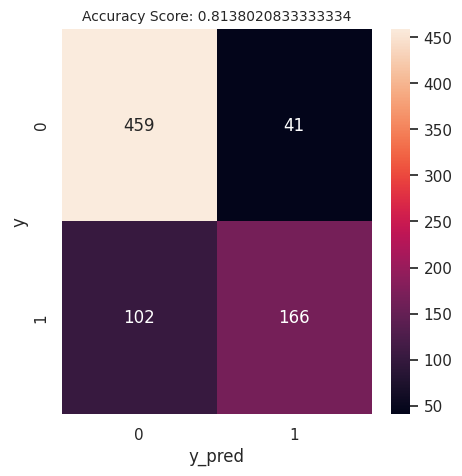

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       354
           1       0.79      0.60      0.68       183

    accuracy                           0.81       537
   macro avg       0.80      0.76      0.77       537
weighted avg       0.81      0.81      0.80       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       146
           1       0.84      0.66      0.74        85

    accuracy                           0.83       231
   macro avg       0.83      0.79      0.80       231
weighted avg       0.83      0.83      0.82       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       500
           1   

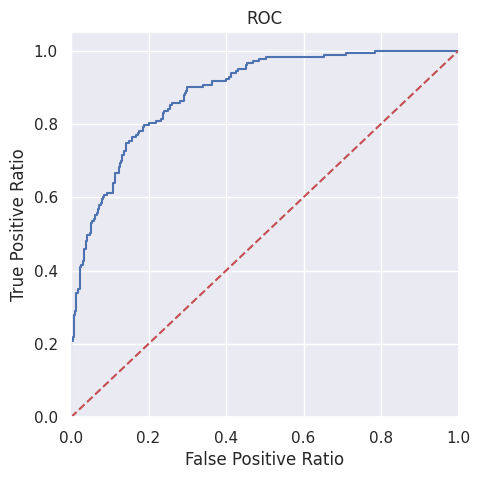

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.792


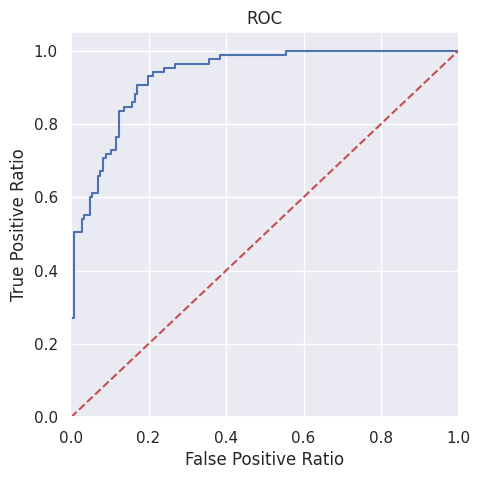

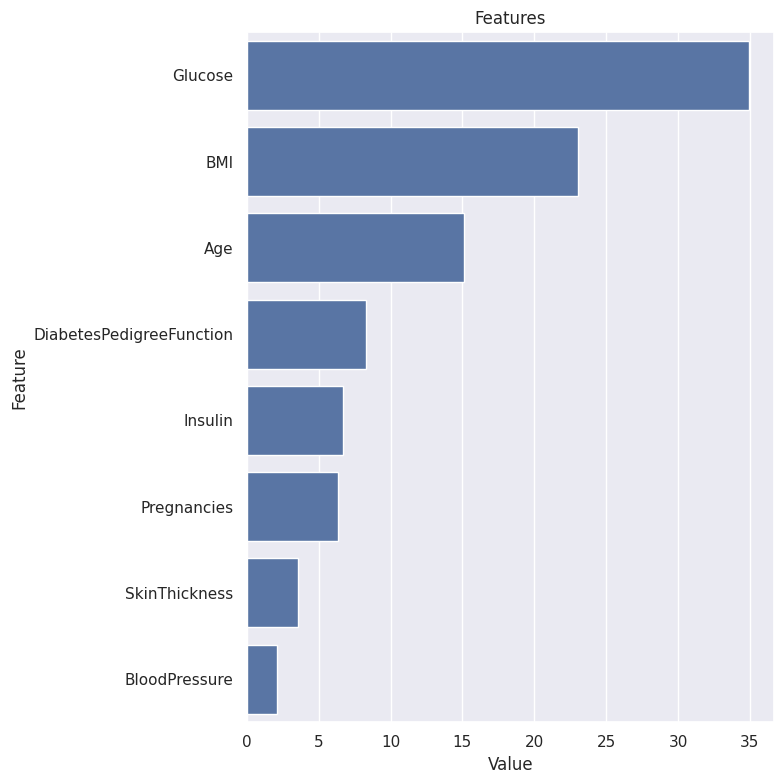

In [83]:
catboost_model_tuned = CatBoost_Model_Tuned(df, "Outcome", results=True, conf_matrix=True, c_report=True, roc=True, plot_importance=True, save_model=True)

# Loading a CatBoost Classifier Model Tuned and Then Prediction

In [84]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [85]:
model_disc = load_model("catboost_model_tuned.pkl")

In [86]:
patient = [[5, 140, 90, 25, 150, 39, 0.55, 65]]
patient= pd.DataFrame(patient,columns=
['Pregnancies','Glucose','BloodPressure','SkinThickness',
'Insulin','BMI','DiabetesPedigreeFunction','Age'],dtype=float)

In [87]:
model_disc.predict(patient)[0]

1